# Classifiers Comparison

This notebook is for those who have just started exploring the world of Neural Network and wondering (as I once did) how well does this new technology compare to the traditional and more understood classifiers?

To answer this question, I'm going to use tabular data from scikit-learn's repository to demonstrate. As you'd expect, I'm going to run a few basic analyses to make sure the data is ready for training before diving into classification.

The matric I'm going to use to compare methods is test-set accuracy. I.e. how well the algorithm classifies data it hasn't seen before.
Split the data into training and testing sets and use the `stratify=y` key. It keeps the two datasets balanced using the original distribution of targets across classes

In [69]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split


from sklearn.datasets import load_wine
np.random.seed(111)

Now that we have our libraries and models, let's download the data and examine its characteristics and features. Find answers to the questions: what's the relationship between variables. What is their distribution, and is the data balanced?

In [70]:
wine = load_wine(as_frame=True)
wine.frame.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


**Impression**: the data has 13 continuous features with different value ranges. This makes the set a perfect candidate for scaling.  
As for the dependent variable, run a quick check to see how many classes are there, what is the count of each. This is an important step to make sure the dataset is balanced! If it's not, then we must address that using a more complex approach!

In [71]:
d = pd.DataFrame(np.bincount(wine.frame.target), columns=['count'], index=wine.target_names)
t = d.sum()
t.name ='Total'
d.append(t.T)

,count
class_0,59
class_1,71
class_2,48
Total,178


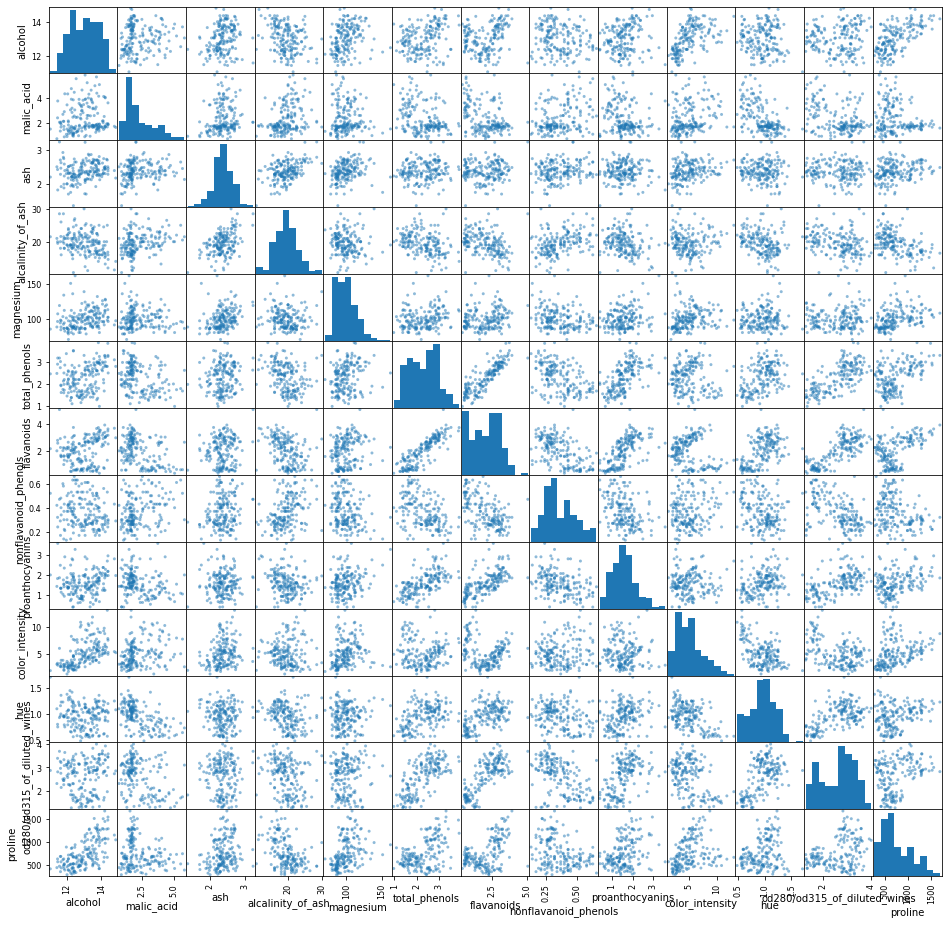

In [72]:
# Scatter plotting the features is a great way to spot any immidiate linear relationship as well as the distribution of features

ax = pd.plotting.scatter_matrix(wine.data, figsize=(16,16))
mask = np.zeros_like(ax, dtype=bool)
mask[np.tril_indices_from(mask)] = True

Right off the bat, there appears to be a linear relationship between `flavanoids` and `total_phenols`. If confirmed, it means multicollinearity in the data, which leads to many problems we want to avoid, including over-fitting! 
*Why over-fitting?* highly correlated features contain similar data. And training a model with two versions of the same data is inherently over-fitting.
So let's look at the correlation matrix to be on the safe side. We are only interested in highly correlated features. So I'm going to filter out absolute values that are below 0.8


In [73]:
corr = wine.data.corr()
corr[abs(corr) > .8 ].fillna("")

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.0,,,,,,,,,,,,
malic_acid,,1.0,,,,,,,,,,,
ash,,,1.0,,,,,,,,,,
alcalinity_of_ash,,,,1.0,,,,,,,,,
magnesium,,,,,1.0,,,,,,,,
total_phenols,,,,,,1.0,0.864564,,,,,,
flavanoids,,,,,,0.864564,1.0,,,,,,
nonflavanoid_phenols,,,,,,,,1.0,,,,,
proanthocyanins,,,,,,,,,1.0,,,,
color_intensity,,,,,,,,,,1.0,,,


There is a strong positive linear association between the two variables mentioned above. It's better to drop one of them to improve our training. 
I'm also going to scale the remaining $X$ variables to [0,1] range. This improves numerical stability in most algorithms, especially NN.


In [74]:
X = wine.data.drop(columns='flavanoids').transform(lambda x: (x-x.min())/(x.max()-x.min())).astype(np.float32)
y = wine.target


Now split the data into training and testing sets. Use the `stratify=y` key. It keeps the two sets balanced using the original distribution of targets across classes.

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)
train_idx, test_idx = train_test_split(wine.frame.index, stratify=y)

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test = X.iloc[test_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

# calculate training bincount again to make sure it's balanced
print(pd.value_counts(y_train))

1    53
0    44
2    36
Name: target, dtype: int64


In [76]:
def print_results(name, cls, x, y , x_t, y_t):
    "Prints out training and testing accuracy"
    print(f'{name} Classifier:\n \tTraining accuracy= %{cls.score(x,y)*100:4.2f}')
    print(f'\tTraining accuracy= %{cls.score(x_t,y_t)*100:4.2f}')

# Naive Bayes Classifier
cln = GaussianNB()
cln.fit(X_train,y_train)
print_results('Naive Bayes Classifier', cln, X_train, y_train, X_test, y_test)

# Decision Tree
cld = DecisionTreeClassifier()
cld.fit(X_train,y_train)
print_results('Decision Tree', cld, X_train, y_train, X_test, y_test)


# K-Nearist Neighbor
knn = KNeighborsClassifier(13)
knn.fit(X_train,y_train)
print_results('KNN', knn, X_train, y_train, X_test, y_test)


# Random Forest
clr = RandomForestClassifier()
clr.fit(X_train,y_train)
print_results('Random Forest', clr, X_train, y_train, X_test, y_test)


# Ada Boost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))
ada.fit(X_train,y_train)
print_results('Ada Boost DT', ada, X_train, y_train, X_test, y_test)

Naive Bayes Classifier Classifier:
 	Training accuracy= %98.50
	Training accuracy= %97.78
Decision Tree Classifier:
 	Training accuracy= %100.00
	Training accuracy= %91.11
KNN Classifier:
 	Training accuracy= %95.49
	Training accuracy= %100.00
Random Forest Classifier:
 	Training accuracy= %100.00
	Training accuracy= %100.00
Ada Boost DT Classifier:
 	Training accuracy= %100.00
	Training accuracy= %97.78


In [89]:
class Net(nn.Module):
    def __init__(self, features, targets):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(features, 64),
                                    nn.LeakyReLU(),
                                    nn.Linear(64, 64),
                                    nn.LeakyReLU(),
                                    nn.Linear(64, targets))
    
    def forward(self,x):
        if x.dtype != torch.float32:
            x = x.float()
        return self.layer(x)
    
    def score(self,x,y):
        out = self(x)
        return out.argmax(dim=1).eq(y).sum()/len(y)

    def learn(self,optim,x,y,epochs,x_test,y_test):
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            optim.zero_grad()
            output = self(x)
            loss = criterion(output,y)
            loss.backward()
            optim.step()
            if epoch%25 ==0:
                test_acc = self.score(x_test,y_test)
                train_acc = self.score(x,y)
                print(f'{epoch:4}: loss: {loss.item():7.4f}, Accuracy: training: {train_acc*100:4.2f}%, testing:{test_acc*100:4.2f}%')
                if np.round(test_acc*100,2)==100: break


net = Net(12, 3)
xx = torch.tensor(X_train.values,dtype=torch.float32)
yy = torch.tensor(y_train.values,dtype=torch.int64)
xx_test = torch.FloatTensor(X_test.values)
yy_test = torch.LongTensor(y_test.values)

In [90]:
epochs =250
lr = 1e-2
optim = torch.optim.Adam(net.parameters(), lr)
net.learn(optim, xx, yy, epochs, xx_test, yy_test)

   0: loss:  1.0943, Accuracy: training: 39.85%, testing:40.00%
  25: loss:  0.0146, Accuracy: training: 100.00%, testing:100.00%


In [91]:
print_results('Neural Network', net, xx, yy, xx_test, yy_test)

Neural Network Classifier:
 	Training accuracy= %100.00
	Training accuracy= %100.00


**Conclusion**  

As you can see from the printed results, the neural network's performance matches the best traditional classifier. It scored an accuracy of 100% in both training and testing datasets!

# 1. Plot High Dimensional Data

To visualize our results we need to reduce its dimensionality. Many packages come with algorithms like PCA,kPCA, and ICA that do exactly that, but my favorite is T-distributed Stochastic Neighbor Embedding (TNSE).  
"It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data."

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE

In [94]:
from sklearn.manifold import TSNE

tsne = TSNE()
a = tsne.fit_transform(X)

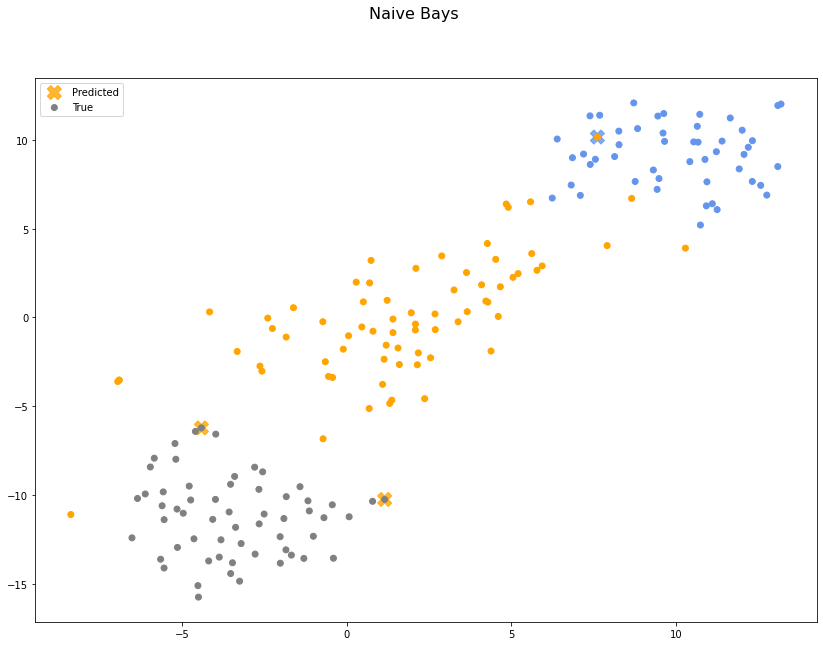

In [95]:
import matplotlib.pyplot as plt

y_hat = cln.predict(X)
b = a[y_hat!=y]
color_map = ['grey', 'orange', 'cornflowerblue']
y_c = [color_map[i] for i in y]
yp_c = [color_map[i] for i in y_hat[y_hat != y]]

with plt.style.context('fast'):
    fig = plt.figure(figsize=(14,10))
    fig.suptitle('Naive Bays', fontsize=16)
    plt.scatter(x=b[:,0],y=b[:,1], c=yp_c, marker='X', s=200, alpha=0.8, label='Predicted')
    plt.scatter(x=a[:,0],y=a[:,1],c=y_c,  marker='o', label='True')
    plt.legend()
